In [115]:
import pandas as pd
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import matplotlib.pyplot as plt

# Загрузка данных

In [253]:
with open('train.pcl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    X = pickle.load(f).drop('Segment', axis=1)

In [254]:
# with open('test.pcl', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     X_ = pickle.load(f)

In [255]:
with open('train.pcl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    y = pickle.load(f)['Segment']

In [229]:
X.shape

(29998184, 17)

In [230]:
X.head()

,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv,hour_shift,local_time,month,date,day,wd,hour,minutes
0,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Забайкальский Край,Чита,android,10.0,6,2021-07-06 00:07:40,7,2021-07-06,6,1,0,7
1,missing,missing,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбургская область,Оренбург,Android,10.0.0,2,2021-07-10 12:38:42,7,2021-07-10,10,5,12,38
2,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,Санкт-Петербург,android,9.0,0,2021-08-04 13:34:29,8,2021-08-04,4,2,13,34
3,missing,missing,tcouchgind.scooterextreme.scooter,2021-08-06 07:35:27,MSK+2,Свердловская область,Екатеринбург,android,9,2,2021-08-06 09:35:27,8,2021-08-06,6,4,9,35
4,missing,missing,com.FidgetTrading3D.game,2021-08-02 20:43:59,MSK,Московская область,Звенигород,android,6.0.1,0,2021-08-02 20:43:59,8,2021-08-02,2,0,20,43


# Preprocessing

In [231]:
def preprocessing(X):
    '''
    Features as input:
    - gamecategory
    - subgamecategory
    - bundle
    - created
    - shift
    - oblast
    - city
    - os
    - osv
    - hour_shift
    - local_time
    - month
    - date
    - day
    - wd
    - hour
    - minutes
    - Segment - output of classification model (1-5 segment numbers)
    '''
    X = X.copy()
    # Уменьшение кол-ва категорий
    night = (X.hour >= 22) | (X.hour < 9)
    work = (X.hour >= 9) & (X.hour < 18)
    evening = (X.hour >= 18) & (X.hour < 22)
    X.hour[night] = 'night'
    X.hour[work] = 'work'
    X.hour[evening] = 'evening'
    
    # Приведение к нижнему регистру
    X.os = X.os.str.lower()
    
    # Выбор версии ОС
    X.osv = X.osv.str.split('.').str[0]
    X['osv'] = X['os'] + '_' + X['osv']
    
    X['subgamecategory'] = X['gamecategory'] + '_' + X['subgamecategory']
    
    X.drop(['created', 
        'shift', 
        'bundle', 
        'local_time', 
        'city', 
        'hour_shift', 
#         'month', 
        'minutes', 
        'day', 
        'subgamecategory', 
        'date'
       ], axis=1, inplace=True)
    
    # X.bundle = X.bundle.str.split('.').str[0]
    
    return X

In [232]:
X = preprocessing(X)

/var/folders/m2/zw_q8jrs4s90wpm6fc798c9w0000gn/T/ipykernel_13951/1890388640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.hour[night] = 'night'
/var/folders/m2/zw_q8jrs4s90wpm6fc798c9w0000gn/T/ipykernel_13951/1890388640.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.hour[work] = 'work'
/var/folders/m2/zw_q8jrs4s90wpm6fc798c9w0000gn/T/ipykernel_13951/1890388640.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.hour[ev

In [233]:
X.head()

,gamecategory,oblast,os,osv,month,wd,hour
0,Games,Забайкальский Край,android,android10,7,1,night
1,missing,Оренбургская область,android,android10,7,5,work
2,Games,Санкт-Петербург,android,android9,8,2,work
3,missing,Свердловская область,android,android9,8,4,work
4,missing,Московская область,android,android6,8,0,evening


In [21]:
X.nunique()

gamecategory    26
oblast          91
os               2
osv             41
month            2
wd               7
hour             3
dtype: int64

# Subset selection

In [22]:
from sklearn.model_selection import train_test_split

In [256]:
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.001, random_state=1, stratify=y, shuffle=True)

In [257]:
del _

In [258]:
X_small = X_small.join(y_small)

In [259]:
X_small.to_csv('part_of_train_data.csv')

In [28]:
le = {}
for col in X.columns:
    le[col] = preprocessing.LabelEncoder()
    le[col].fit(X[col])

    X_small[col] = le[col].transform(X_small[col])

# Strategies and Algorithms for Clustering Large Datasets: A Review

https://upcommons.upc.edu/bitstream/handle/2117/23415/R13-11.pdf

In [234]:
def table_generation(X):
    NUMBER_OF_PLACES = 2

    dict_info = {}
    for cluster in range(X.cluster.nunique()):
        dict_ = {}
        for col in X.columns[:-1]:
            X_clustered = X[X.cluster == cluster]
            a = (X_clustered[col].value_counts() / len(X_clustered) * 100)[:NUMBER_OF_PLACES].to_dict()
            temp = [str(i)+f' ({str(round(j,1))}%)' for i,j in zip(a.keys(), a.values())]
            while len(temp) < NUMBER_OF_PLACES:
                temp += ['- (0%)']
            dict_[col] = temp
        dict_info[f'Кластер № {cluster}'] = pd.DataFrame(dict_, index=['Самый частый', 'Второе место'])

    return pd.concat(dict_info)

# MCA + KMeans

Remember that u can always get principal components for categorical variables using a multiple correspondence analysis (MCA), which will give principal components, and you can get then do a separate PCA for the numerical variables, and use the combined as input into your clustering.

https://github.com/esafak/mca/blob/master/docs/usage.rst

In [56]:
# !pip install mca

In [47]:
import mca

In [48]:
mca_ = mca.MCA(X_small)

In [53]:
print(mca_.L)

[0.00121631]


In [57]:
mca_results = mca_.fs_r(0.99)

In [59]:
mca_results

(29998, 1)

In [70]:
clustering = KMeans(5).fit(mca_results)
clustering

clustering.labels_

array([1, 2, 3, ..., 2, 0, 3], dtype=int32)

In [87]:
for col in X.columns:
    X_small[col] = le[col].inverse_transform(X_small[col])

<AxesSubplot:xlabel='osv', ylabel='Count'>

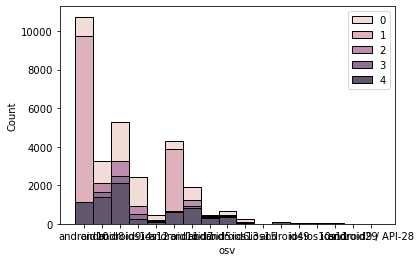

In [89]:
sns.histplot(data=X_small, x="osv", hue=clustering.labels_, multiple="stack")

In [74]:
X_small['cluster'] = clustering.labels_

In [172]:
table_generation(X_small)

gamecategory                        oblast  \
Кластер № 0 Самый частый    Games (51.8%)                Москва (33.0%)   
            Второе место  missing (41.5%)               missing (14.8%)   
Кластер № 1 Самый частый    Games (50.4%)                Москва (21.1%)   
            Второе место  missing (43.6%)   Свердловская область (9.3%)   
Кластер № 2 Самый частый  missing (49.4%)               missing (21.6%)   
            Второе место    Games (45.2%)           Башкортостан (9.0%)   
Кластер № 3 Самый частый    Games (83.0%)               missing (71.8%)   
            Второе место   missing (6.5%)        Алтайский край (11.0%)   
Кластер № 4 Самый частый  missing (47.8%)  Свердловская область (11.7%)   
            Второе место    Games (47.4%)       Санкт-Петербург (11.0%)   

                                        os                osv      month  \
Кластер № 0 Самый частый   android (73.0%)   android9 (26.9%)  8 (61.9%)   
            Второе место       ios (27.0%)      ios14 (20.1%)  7 (38.1%)   
Кластер № 1 Самый частый  android (100.0%)  android10 (72.9%)  8 (68.1%)   
            Второе место            - (0%)  android11 (27.1%)  7 (31.9%)   
Кластер № 2 Самый частый   android (77.1%)   android9 (34.2%)  8 (61.5%)   
            Второе место       ios (22.9%)   android8 (20.3%)  7 (38.5%)   
Кластер № 3 Самый частый   android (71.5%)   android9 (31.7%)  8 (61.8%)   
            Второе место       ios (28.5%)      ios14 (23.5%)  7 (38.2%)   
Кластер № 4 Самый частый   android (94.1%)   android9 (29.4%)  8 (66.4%)   
            Второе место        ios (5.9%)   android8 (19.2%)  7 (33.6%)   

                                 wd           hour    Segment  
Кластер № 0 Самый частый  0 (20.6%)   work (56.4%)  3 (38.7%)  
            Второе место  1 (18.9%)  night (26.9%)  5 (30.6%)  
Кластер № 1 Самый частый  0 (21.6%)   work (57.5%)  5 (34.5%)  
            Второе место  1 (20.2%)  night (24.5%)  4 (33.4%)  
Кластер № 2 Самый частый  0 (21.4%)   work (55.7%)  3 (37.7%)  
            Второе место  1 (19.5%)  night (26.3%)  4 (30.8%)  
Кластер № 3 Самый частый  0 (22.4%)   work (54.5%)  3 (41.2%)  
            Второе место  1 (20.7%)  night (28.4%)  5 (32.0%)  
Кластер № 4 Самый частый  0 (21.6%)   work (57.5%)  5 (33.1%)  
            Второе место  1 (19.4%)  night (24.1%)  4 (32.7%)

# [TODO] Latent Class Analysis

https://www.oxfordclinicalpsych.com/view/10.1093/med:psych/9780190243654.001.0001/med-9780190243654-chapter-15?gclid=Cj0KCQiAnaeNBhCUARIsABEee8X2xl45364ttSKCkADrf7D1i8u2JBIcGgUfuNIGlEwKbN9yFvIgiqMaAqC6EALw_wcB

https://en.wikipedia.org/wiki/Latent_class_model

https://github.com/dasirra/latent-class-analysis/blob/master/src/test_lca.ipynb

# AgglomerativeClustering

In [175]:
for col in X.columns:
    X_small[col] = le[col].transform(X_small[col])

In [176]:
clustering = AgglomerativeClustering().fit(X_small.drop('cluster', axis=1))
clustering

clustering.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [177]:
X_small['cluster'] = clustering.labels_

In [178]:
# X_small['segment'] = y_small

In [180]:
X_small['cluster'].value_counts()

0    18119
1    11879
Name: cluster, dtype: int64

In [33]:
X_small['cluster'].value_counts()

0    18119
1    11879
Name: cluster, dtype: int64

In [34]:
X_small.head()

,gamecategory,oblast,os,osv,month,wd,hour,Segment,cluster,segment
24312150,25,48,0,2,1,0,1,4,0,4
29973861,25,21,0,26,0,6,1,3,0,3
30738000,7,5,0,27,1,0,0,5,0,5
42373048,7,48,1,34,1,3,2,3,0,3
15067441,7,36,0,26,0,4,2,3,0,3


In [37]:
import seaborn as sns

<AxesSubplot:xlabel='Segment', ylabel='Count'>

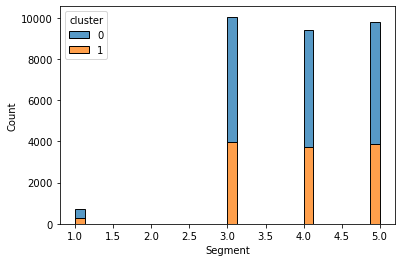

In [39]:
sns.histplot(data=X_small, x="cluster", hue="Segment", multiple="stack")

In [183]:
for col in X.columns:
    X_small[col] = le[col].inverse_transform(X_small[col])

In [184]:
table_generation(X_small)

gamecategory                        oblast  \
Кластер № 0 Самый частый    Games (50.7%)                Москва (28.0%)   
            Второе место  missing (43.3%)               missing (13.1%)   
Кластер № 1 Самый частый    Games (50.9%)  Свердловская область (17.8%)   
            Второе место  missing (43.0%)       Санкт-Петербург (17.5%)   

                                       os                osv      month  \
Кластер № 0 Самый частый  android (88.5%)  android10 (35.7%)  8 (65.2%)   
            Второе место      ios (11.5%)   android9 (17.5%)  7 (34.8%)   
Кластер № 1 Самый частый  android (89.8%)  android10 (35.9%)  8 (65.7%)   
            Второе место      ios (10.2%)   android9 (17.9%)  7 (34.3%)   

                                 wd           hour    Segment  
Кластер № 0 Самый частый  0 (21.4%)   work (56.7%)  3 (33.5%)  
            Второе место  1 (19.6%)  night (25.9%)  5 (32.7%)  
Кластер № 1 Самый частый  0 (21.2%)   work (57.4%)  3 (33.5%)  
            Второе место  1 (19.8%)  night (24.3%)  5 (32.7%)

Вывод: работает недостаточно хорошо

# K-Modes

https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/

In [205]:
# !pip install kmodes
from kmodes.kmodes import KModes

In [206]:
# for col in X.columns:
#     X_small[col] = le[col].transform(X_small[col])

In [218]:
# Elbow curve to find optimal K
cost = []
K = range(0, 20)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0)
    kmode.fit_predict(X_small.drop('cluster', axis=1))
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [244]:
# Building the model with 8 clusters
kmode = KModes(n_clusters=8, init = "random", n_init = 5, verbose=0, random_state=10)
clusters = kmode.fit_predict(X_small.drop('cluster', axis=1))
clusters

array([0, 3, 2, ..., 1, 3, 1], dtype=uint16)

In [245]:
X_small['cluster'] = clusters

<AxesSubplot:xlabel='cluster', ylabel='Count'>

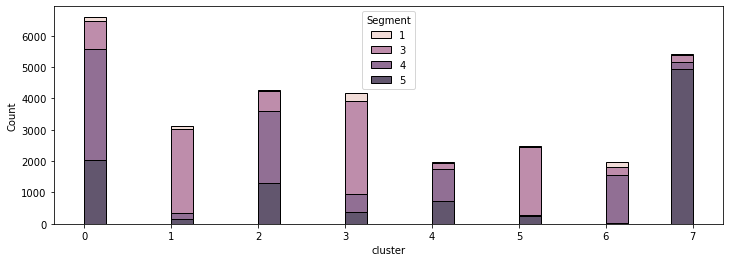

In [246]:
plt.figure(figsize=(12,4))
sns.histplot(data=X_small, x="cluster", hue="Segment", multiple="stack")

In [247]:
# for col in X.columns:
#     X_small[col] = le[col].inverse_transform(X_small[col])

In [248]:
table_generation(X_small)

gamecategory                        oblast  \
Кластер № 0 Самый частый  missing (79.5%)                Москва (20.7%)   
            Второе место    Games (14.6%)     Краснодарский край (7.1%)   
Кластер № 1 Самый частый    Games (79.4%)                Москва (28.5%)   
            Второе место  missing (11.0%)     Краснодарский край (7.9%)   
Кластер № 2 Самый частый    Games (88.1%)                Москва (18.7%)   
            Второе место   missing (6.7%)                missing (7.9%)   
Кластер № 3 Самый частый  missing (73.7%)               missing (18.2%)   
            Второе место    Games (21.4%)     Краснодарский край (7.4%)   
Кластер № 4 Самый частый  missing (72.8%)  Свердловская область (22.8%)   
            Второе место    Games (21.2%)        Санкт-Петербург (6.7%)   
Кластер № 5 Самый частый    Games (89.4%)             Татарстан (15.3%)   
            Второе место   missing (5.0%)     Краснодарский край (8.0%)   
Кластер № 6 Самый частый  missing (67.1%)                Москва (25.1%)   
            Второе место    Games (28.0%)     Краснодарский край (7.4%)   
Кластер № 7 Самый частый    Games (72.8%)                Москва (19.6%)   
            Второе место  missing (20.9%)                missing (6.8%)   

                                       os                osv      month  \
Кластер № 0 Самый частый  android (96.6%)  android11 (35.4%)  8 (79.9%)   
            Второе место       ios (3.4%)  android10 (22.8%)  7 (20.1%)   
Кластер № 1 Самый частый      ios (76.7%)      ios14 (62.3%)  7 (71.6%)   
            Второе место  android (23.3%)       ios12 (8.0%)  8 (28.4%)   
Кластер № 2 Самый частый  android (95.4%)   android8 (36.7%)  8 (75.3%)   
            Второе место       ios (4.6%)  android10 (19.3%)  7 (24.7%)   
Кластер № 3 Самый частый  android (99.6%)  android10 (63.1%)  7 (77.2%)   
            Второе место       ios (0.4%)   android9 (13.1%)  8 (22.8%)   
Кластер № 4 Самый частый  android (98.8%)   android9 (59.6%)  8 (86.7%)   
            Второе место       ios (1.2%)  android10 (16.2%)  7 (13.3%)   
Кластер № 5 Самый частый  android (95.7%)  android11 (33.3%)  8 (79.0%)   
            Второе место       ios (4.3%)  android10 (25.7%)  7 (21.0%)   
Кластер № 6 Самый частый  android (99.5%)  android10 (63.9%)  7 (84.2%)   
            Второе место       ios (0.5%)   android9 (12.1%)  8 (15.8%)   
Кластер № 7 Самый частый  android (93.9%)  android10 (62.8%)  8 (98.2%)   
            Второе место       ios (6.1%)   android9 (12.7%)   7 (1.8%)   

                                 wd             hour    Segment  
Кластер № 0 Самый частый  1 (40.9%)     work (79.5%)  4 (53.6%)  
            Второе место  0 (18.9%)  evening (10.6%)  5 (30.9%)  
Кластер № 1 Самый частый  5 (21.1%)    night (43.6%)  3 (86.2%)  
            Второе место  4 (15.9%)     work (31.3%)   4 (5.8%)  
Кластер № 2 Самый частый  0 (58.5%)     work (68.0%)  4 (53.9%)  
            Второе место   3 (8.9%)    night (17.1%)  5 (30.1%)  
Кластер № 3 Самый частый  2 (26.1%)    night (53.4%)  3 (71.0%)  
            Второе место  0 (15.6%)     work (28.3%)  4 (14.2%)  
Кластер № 4 Самый частый  1 (35.0%)    night (77.2%)  4 (51.3%)  
            Второе место  0 (15.8%)  evening (16.2%)  5 (37.1%)  
Кластер № 5 Самый частый  5 (35.3%)     work (69.4%)  3 (87.8%)  
            Второе место  6 (16.8%)  evening (20.1%)   5 (9.7%)  
Кластер № 6 Самый частый  3 (39.1%)  evening (68.4%)  4 (77.3%)  
            Второе место  0 (19.2%)     work (25.8%)  3 (12.7%)  
Кластер № 7 Самый частый  2 (48.0%)     work (81.6%)  5 (91.3%)  
            Второе место  1 (21.3%)    night (13.2%)   3 (4.2%)

In [249]:
with open('model.pickle', 'wb') as f:
    pickle.dump(kmode, f)

In [261]:
def model_inference(X):
    X = X.copy()
    if 'cluster' in X.columns:
        X = X.drop('cluster', axis=1)
    
    with open('model.pickle', 'rb') as f:
        kmode = pickle.load(f)
    
    clusters = kmode.predict(X)
    return clusters

In [ ]:
Вывод: работает хорошо

# ROCK 

http://theory.stanford.edu/~sudipto/mypapers/categorical.pdf

https://pyclustering.github.io/docs/0.9.0/html/d8/dde/classpyclustering_1_1cluster_1_1rock_1_1rock.html

https://stackoverflow.com/questions/30211577/clustering-categorical-data-set-with-distance-based-approach

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.rock import rock
# Create instance of ROCK algorithm for cluster analysis. Seven clusters should be allocated.
rock_instance = rock(X_small.drop('cluster', axis=1), 1.0, 8)
# Run cluster analysis.
rock_instance.process()
# Obtain results of clustering.
clusters = rock_instance.get_clusters()
# Visualize clustering results.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.show()

# Gower distance

Gower Similarity (GS) was first defined by J. C. Gower in 1971 [2]. To calculate the similarity between observations i and j (e.g., two customers), GS is computed as the average of partial similarities (ps) across the m features of the observation.

https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad

In [15]:
for col in X.columns:

    X_small[col] = le[col].inverse_transform(X_small[col])

/var/folders/m2/zw_q8jrs4s90wpm6fc798c9w0000gn/T/ipykernel_46970/1990368804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_small[col] = le[col].inverse_transform(X_small[col])


In [219]:
import gower
from sklearn.cluster import DBSCAN

dist_matrix = gower.gower_matrix(X_small.drop('cluster', axis=1))
db = DBSCAN(eps = 0.3, min_samples = 10, metric = "precomputed").fit(dist_matrix)
labels = db.labels_

In [220]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [221]:
X_small['cluster'] = labels

In [227]:
X_small.head()

,gamecategory,oblast,os,osv,month,wd,hour,Segment,cluster
24312150,missing,Москва,android,android10,8,0,night,4,0
29973861,missing,Забайкальский Край,android,android8,7,6,night,3,0
30738000,Games,Алтайский край,android,android9,8,0,evening,5,0
42373048,Games,Москва,ios,ios14,8,3,work,3,0
15067441,Games,Краснодарский край,android,android8,7,4,work,3,0


In [226]:
table_generation(X_small)

gamecategory          oblast               os  \
Кластер № 0 Самый частый    Games (50.8%)  Москва (16.9%)  android (89.0%)   
            Второе место  missing (43.2%)  missing (7.9%)      ios (11.0%)   

                                        osv      month         wd  \
Кластер № 0 Самый частый  android10 (35.8%)  8 (65.4%)  0 (21.4%)   
            Второе место   android9 (17.6%)  7 (34.6%)  1 (19.6%)   

                                   hour    Segment  
Кластер № 0 Самый частый   work (57.0%)  3 (33.5%)  
            Второе место  night (25.3%)  5 (32.7%)

Вывод: работает недостаточно хорошо

# [TODO] Neural Networks for Clustering in Python

https://matthew-parker.rbind.io/post/2021-01-16-pytorch-keras-clustering/#

# Clustering to id for test set

In [266]:
with open('.pcl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    X_ = pickle.load(f)

In [267]:
del X_

Кластер № 0


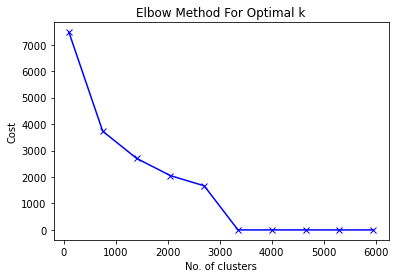

Кластер № 1


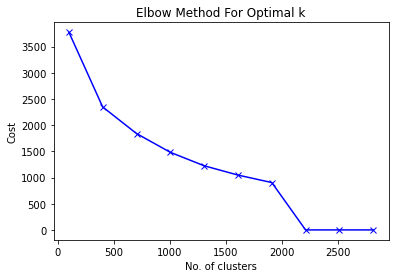

Кластер № 2


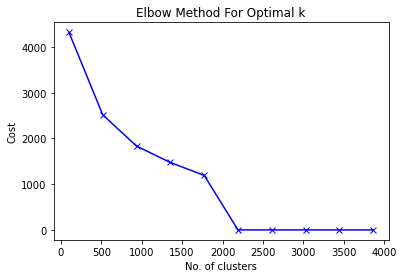

Кластер № 3


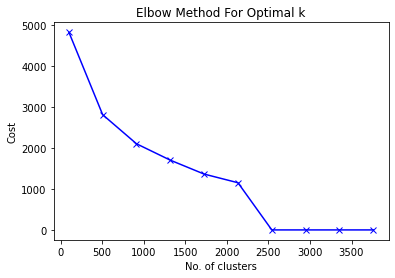

Кластер № 4


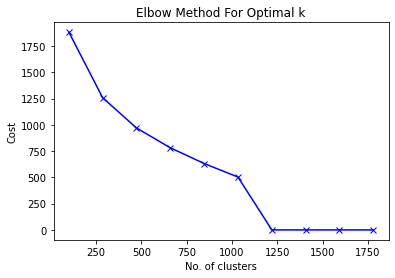

Кластер № 5


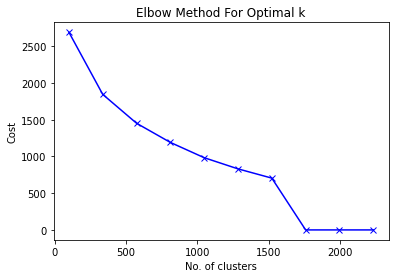

Кластер № 6


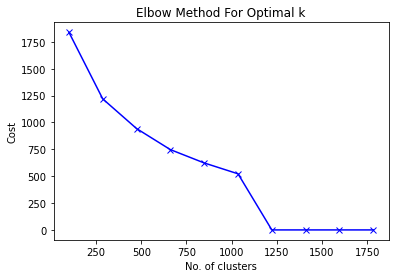

Кластер № 7


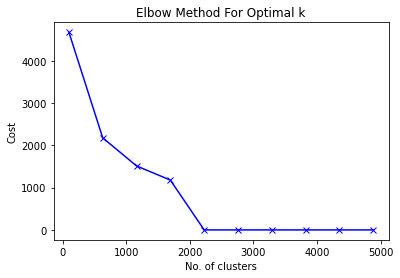

In [291]:
for num in range(X.cluster.nunique()):
    # Elbow curve to find optimal K
    cost = []
    K = np.linspace(100, len(X[X.cluster==num]), 11, dtype=int)[:-1]
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 2, verbose=0, random_state=1)
        kmode.fit_predict(X[X.cluster==num].drop(['cluster', 'Segment'], axis=1))
        cost.append(kmode.cost_)

    print(f'Кластер № {num}')
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Method For Optimal k')
    plt.show()

- Кластер 0 - 3000
- Кластер 1 - 1900
- Кластер 2 - 1800
- Кластер 3 - 2200
- Кластер 4 - 1000
- Кластер 5 - 1500
- Кластер 6 - 1000
- Кластер 7 - 1700
- всего - 14100